In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
fpath = tf.keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)

dataset = np.load(fpath)

819216384/819200096 [==============================] - 227s 0us/step


In [10]:
dataset1 = np.swapaxes(dataset, 0, 1)
dataset2 = np.transpose(dataset, (1, 0, 2, 3))
dataset.shape, dataset1.shape, dataset2.shape

((20, 10000, 64, 64), (10000, 20, 64, 64), (10000, 20, 64, 64))

In [11]:
dataset2 = dataset2[:1000, ...]

dataset3 = np.expand_dims(dataset2, axis=-1) 

# dataset2.shape, dataset3.shape

In [12]:
dataset3.shape

(1000, 20, 64, 64, 1)

In [13]:
indexes = np.arange(dataset3.shape[0])
np.random.shuffle(indexes) 

train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]):]

train_dataset = dataset3[train_index]
val_dataset = dataset3[val_index] 


train_dataset = train_dataset / 255. 
val_dataset = val_dataset / 255. 

def create_shifted_frames(data): 
    x = data[:, 0 : data.shape[1] -1, :, :]
    y = data[:, 1 : data.shape[1] :, :]
    
    return x, y 

x_train, y_train = create_shifted_frames(train_dataset) 
x_val, y_val = create_shifted_frames(val_dataset) 


x_train.shape, y_train.shape, x_val.shape, y_val.shape

((18, 19, 64, 64, 1),
 (18, 19, 64, 64, 1),
 (982, 19, 64, 64, 1),
 (982, 19, 64, 64, 1))

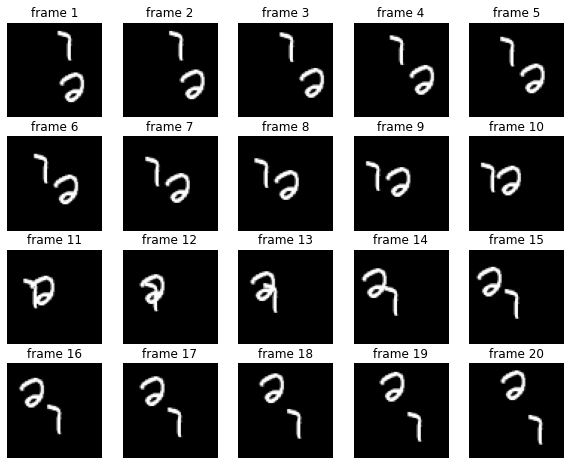

In [14]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap='gray')
    ax.set_title(f'frame {idx + 1}')
    ax.axis('off')
    
plt.show() 

In [16]:
*x_train.shape[2:]

SyntaxError: can't use starred expression here (Temp/ipykernel_11272/3882639398.py, line 1)

In [17]:
inputs = tf.keras.Input(shape=(None, *x_train.shape[2:]))

x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding='same', return_sequences=True, activation='relu')(inputs) 
x = tf.keras.layers.BatchNormalization()(x) 

x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(x) 
x = tf.keras.layers.BatchNormalization()(x) 

x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding='same', return_sequences=True, activation='relu')(x) 
x = tf.keras.layers.BatchNormalization()(x) 

x = tf.keras.layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same')(x) 

model = tf.keras.models.Model(inputs=inputs, outputs=x) 

model.compile(loss=tf.keras.losses.binary_crossentropy, 
              optimizer=tf.keras.optimizers.Adam())

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  patience=5)

epochs = 20 
batch_size = 5 

model.fit(x_train, 
           y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           validation_data=(x_val, y_val), 
           callbacks=[early_stopping, reduce_lr]
           )

Epoch 1/20
4/4 [==============================] - 651s 208s/step - loss: 0.7830 - val_loss: 0.6775
Epoch 2/20
4/4 [==============================] - 660s 213s/step - loss: 0.6951 - val_loss: 1.5627
Epoch 3/20
4/4 [==============================] - 656s 212s/step - loss: 0.6294 - val_loss: 0.7706
Epoch 4/20
4/4 [==============================] - 657s 212s/step - loss: 0.5649 - val_loss: 0.7837
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.4775 

KeyboardInterrupt: 

In [4]:
seq_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, 40, 40, 1)), 
    tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding='same', activation='sigmoid')
])

seq_model.compile(loss='binary_crossentropy', optimizer='adadelta')

In [5]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80 
    col = 80 
    
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float) 
    
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    
    for i in range(n_samples): 
        
        n = np.random.randint(3, 8)
        
        for j in range(n):
            
            x_start = np.random.randint(20, 60)
            y_start = np.random.randint(20, 60)
            
            direction_x = np.random.randint(0, 3) - 1
            direction_y = np.random.randint(0, 3) - 1
            
            w = np.random.randint(2, 4) 
            
            
            for t in range(n_frames):
                x_shift = x_start + direction_x + t 
                y_shift = y_start + direction_y + t 
                
                noisy_movies[i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0] += 1
                
                if np.random.randint(0, 2): 
                    
                    noise_f = (-1) ** np.random.randint(0, 2) 
                    
                    noisy_movies[i, t, x_shift - w - 1 : x_shift + w + 1, y_shift - w - 1 : y_shift + w + 1, 0] += (noise_f * 0.1) 
                    
            
            # 정답 데이터
            x_shift = x_start + direction_x * (t + 1) 
            y_shift = y_start + direction_y * (t + 1) 
            shifted_movies[i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0] += 1
            
            
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
                
                
    noisy_movies[noisy_movies >= 1] = 1 
    shifted_movies[shifted_movies >= 1] = 1
    
    return noisy_movies, shifted_movies
        
        
    
    

In [6]:
epochs = 1

noisy_movies, shifted_movies = generate_movies(n_samples=1200) 

seq_model.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10, epochs=epochs, verbose=2, validation_split=0.1)

KeyboardInterrupt: 